# Проект: Определение стоимости автомобилей

[yandex_practicum](https://practicum.yandex.ru/trainer/data-scientist/lesson/2372bd1e-1ce6-4b9c-b73e-d1ce7eb59441/)

Описание проекта:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать <font color='red'>рыночную стоимость своего автомобиля. </font>

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Описание данных

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач

- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## 1.  Подготовка данных


### 1.1 Загружаем библиотеки и читаем данные

In [238]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

# библиотека для оценки корреляции
from phik import phik_matrix

# библиотека для оценки важности признаков Шепли (SHAP)
import shap

# бибилотеки для подготовки данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE


# библиотеки для пайплайнов
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# библиотеки для линейной регрессии
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer, root_mean_squared_error

# библиотеки для градиентного бустинга
from catboost import CatBoostRegressor
from xgboost import XGBRegressor



# библиотека решающих деревьев
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


# бибилиотека для графика ROC-кривой и расчёта ROC-AUC
from sklearn.metrics import roc_auc_score, RocCurveDisplay



# добавим библиотеку для построения scatter диаграмм рассеяния с тренд-линиями
import plotly.express as px 
import plotly.graph_objects as go



ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

In [144]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('/Users/tony_builder/Documents/GitHub/studying/yandex_practicum/12_numeric_methods/data/autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [145]:
data.groupby(['Brand', 'Model', 'Gearbox']).agg({'FuelType': list}).reset_index()

,Brand,Model,Gearbox,FuelType
0,alfa_romeo,145,manual,"[petrol, petrol, petrol, petrol, petrol, petro..."
1,alfa_romeo,147,auto,"[petrol, petrol, petrol, petrol, petrol, petro..."
2,alfa_romeo,147,manual,"[gasoline, petrol, petrol, petrol, petrol, pet..."
3,alfa_romeo,156,auto,"[petrol, petrol, petrol, petrol, petrol, petro..."
4,alfa_romeo,156,manual,"[petrol, petrol, petrol, petrol, petrol, petro..."
...,...,...,...,...
567,volvo,v60,manual,"[gasoline, petrol, gasoline, gasoline, gasolin..."
568,volvo,v70,auto,"[petrol, gasoline, gasoline, petrol, gasoline,..."
569,volvo,v70,manual,"[petrol, petrol, petrol, petrol, petrol, petro..."
570,volvo,xc_reihe,auto,"[gasoline, petrol, petrol, gasoline, petrol, g..."


In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 1.2 Ищем пустые значения

In [147]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Итак, пропущенные значения в столбцах:
- тип кузова
- тип коробки передач
- модель
- тип топлива
- столбец с информацией о ремонте машины (да/нет)

Объем пропущенных данных довольно большой - от 5 до 20% 


Для начала приведем типы данных к верному:
- DateCrawled, DateCreated, LastSeen - к datetime 

Остальные типы данных верные

In [148]:

data = data.astype({'DateCrawled':'datetime64','DateCreated':'datetime64','LastSeen':'datetime64',},errors='ignore')
data[['DateCrawled', 'DateCreated', 'LastSeen']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DateCrawled  354369 non-null  datetime64[ns]
 1   DateCreated  354369 non-null  datetime64[ns]
 2   LastSeen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB


Теперь посмотрим на дубликаты

In [149]:
data.duplicated().sum()

4

Удалим дубликаты

In [150]:
data.drop_duplicates(inplace=True)

#### 1.2.1 Проведем исследовательский анализ данных по признакам с пропущенными значениями

Сначала создадим нужные функции:

- вытягивания имени из переменной (для корректного наименования графиков)
- построения гистограммы и boxplot для количественных признаков
- построения столбчатых диаграмм для категориальных признаков

- сборная функция построения всей аналитики для любого датасета

In [151]:
# функция получения имени переменной

def get_var_name(var, caller_locals):
    import inspect
    for name, value in caller_locals.items():
        if value is var:
            return name
    return None

In [152]:
# функция для построения гистограммы и boxplot для любого столбца любого датафрейма

def plot_hist_boxplot(some_df, col, col_name, dataset_name):

    df_for_plot= some_df[col]

    # Рассчитываем квартили
    q25, q75 = df_for_plot.quantile(0.25), df_for_plot.quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    # Создаем новый график
    plt.figure(figsize=(10, 10))

    # Строим гистограмму
    plt.subplot(2, 1, 1)  # 2 строки, 1 столбец, график 1
    plt.hist(df_for_plot, bins=20, range=(min_val, max_val))
    plt.title(f'Гистограмма для признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значения признака {col_name}')
    plt.ylabel(f'Частота')


    # Помечаем квартили на гистограмме
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()

    # Строим график boxplot
    plt.subplot(2, 1, 2)  # 2 строки, 1 столбец, график 2
    plt.boxplot(df_for_plot, vert=False)
    plt.title(f'Boxplot признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'Значение признака {col_name}')

    # Помечаем квартили на boxplot
    plt.axvline(q25, color='r', linestyle='--', label='25th percentile')
    plt.axvline(q75, color='g', linestyle='--', label='75th percentile')
    plt.legend()


    # Показываем графики
    plt.tight_layout()  # Для автоматического выравнивания графиков
    plt.show()


        

In [153]:
# функция построения столбчатой диаграммы

def barplot_df(dataset, col, col_name, dataset_name, dropna=False):
    dataset[col].value_counts(dropna=dropna).plot(kind='bar', legend=True, figsize=(10,5))
    plt.title(f'Диаграмма частоты признака {col_name} для датасета {dataset_name}')
    plt.xlabel(f'значение признака {col_name}')
    plt.ylabel(f'Частота признака {col_name}')
    plt.show()

    

In [154]:
# функция получения аналитических данных для любой таблицы

def analysis_df(some_df: pd.DataFrame, dropna=False):
    # блок вытягивания имени
    import inspect
    caller_locals = inspect.currentframe().f_back.f_locals

    dataset_name = get_var_name(some_df, caller_locals)
    

    print(f'Статистический анализ таблицы {dataset_name}')  # печатаем имя таблицы (из переменной)
    display(some_df.describe().T)

    # блок построения гистограмм и диаграмм

    cat_col_list = some_df.select_dtypes(exclude='number').columns.tolist()
    num_col_list = some_df.select_dtypes(include='number').columns.tolist()
    
    #dict_names = {v: k for k,v in col_name_dict.items()}

    for col in num_col_list:
        plot_hist_boxplot(some_df=some_df, col_name=col, col=col, dataset_name=dataset_name)

    for col in cat_col_list:   # для категориальных столбцов
        try:
            barplot_df(dataset=some_df, col_name=col, col=col, dataset_name=dataset_name, dropna=dropna)
        except KeyError:
            continue

Построим распределения по каждому из признаков с пустыми значениями

Статистический анализ таблицы None


,count,unique,top,freq
VehicleType,316875,8,sedan,91457
Gearbox,334532,2,manual,268249
Model,334660,250,golf,29232
Repaired,283211,2,no,247158
FuelType,321470,7,petrol,216349


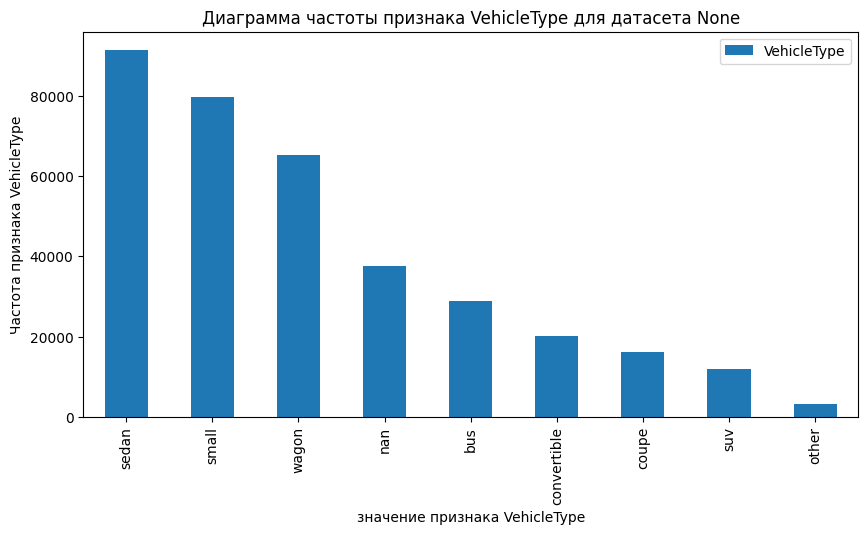

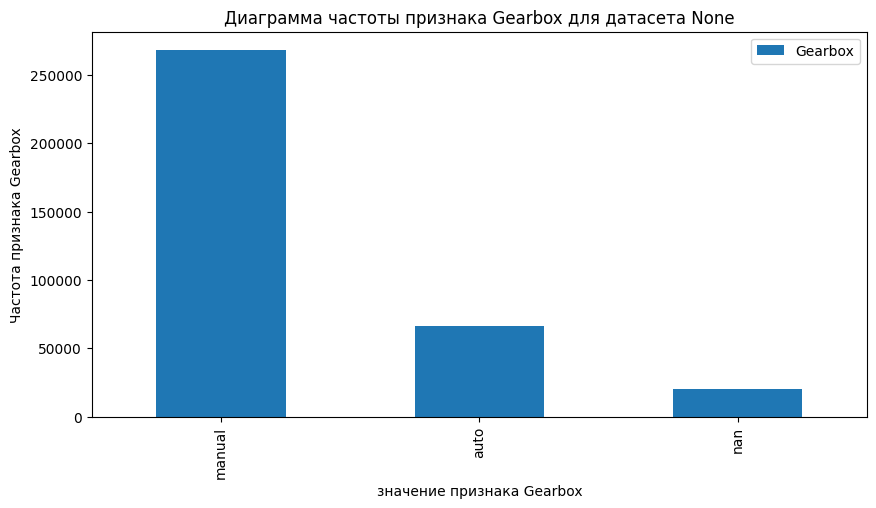

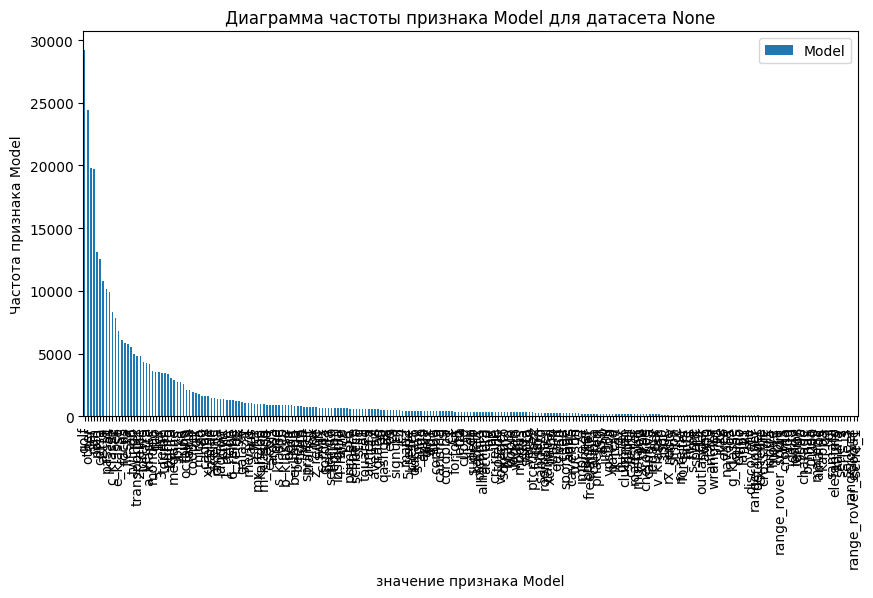

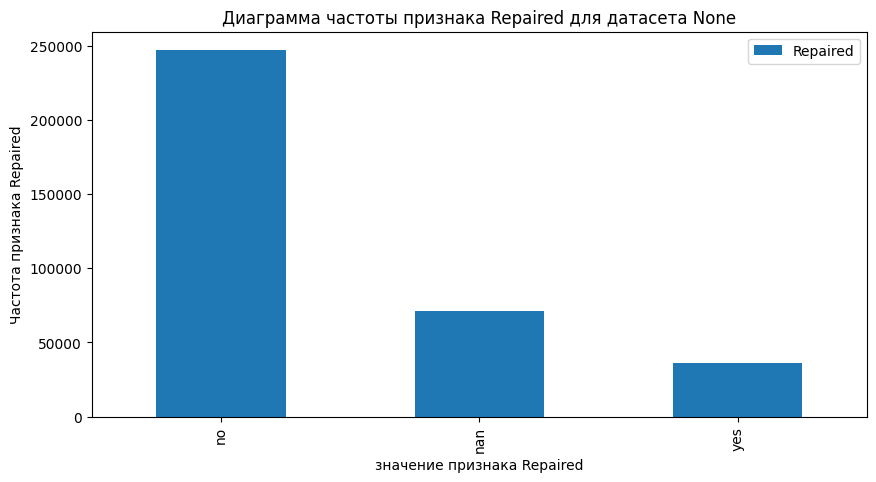

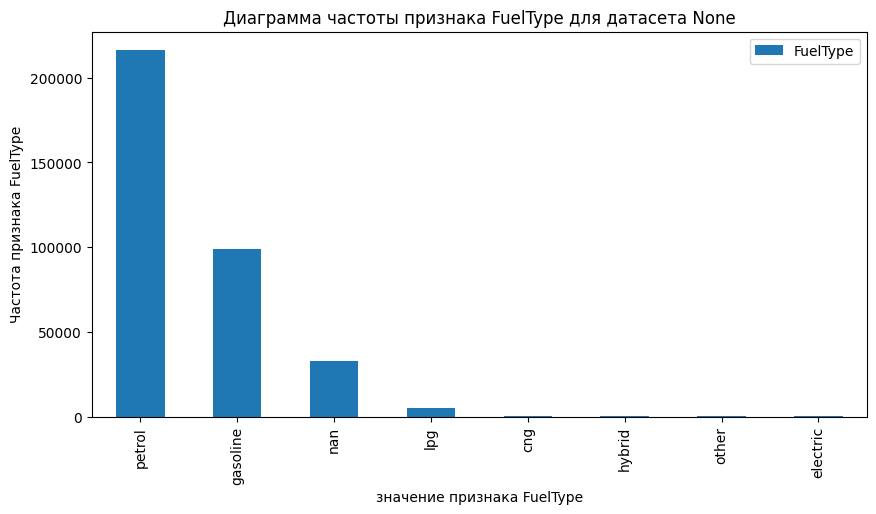

In [155]:
analysis_df(data[['VehicleType', 'Gearbox', 'Model', 'Repaired', 'FuelType']])

Начнем c показателя Тип топлива

1) Судя по информации из открытых источников, Petrol и Gasoline - это один и тот же вид топлива: иначе говоря бензин. Их можно заменить на единое значение - пусть это будет Petrol

2) lpg and cng - два вида газа, которые существенно отличаются. Поэтому их оставим раздельными

3) в целом, колоссальным значением обладают именно бензиновые двигатели по сравнению со всеми остальными(это и понятно)
Заполним пустые значения типа топлива по бренду и модели - чтобы исключить вероятность попадания на электричесмкие или гибридные автомобили

In [156]:
data.loc[data['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [157]:
# Группируем данные по столбцам "Марка" и "Модель", используем режим для нахождения самого частого значения
from statistics import mode

fill_values = data.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: mode(x.dropna()))

data_1 = data.copy()

data_1['FuelType'] = data_1['FuelType'].fillna(fill_values)

In [158]:
fill_values.unique()

array(['petrol', nan], dtype=object)

Статистический анализ таблицы None


,count,unique,top,freq
FuelType,347202,6,petrol,340800


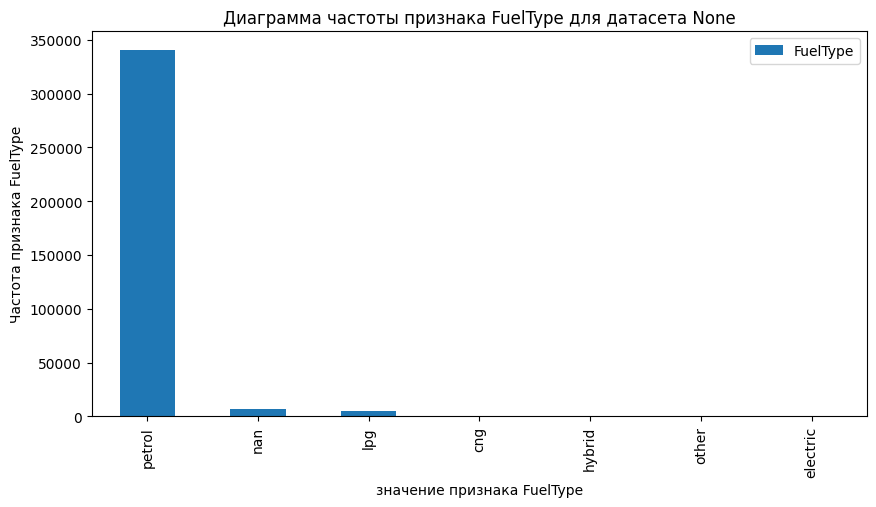

In [159]:
analysis_df(data_1[['FuelType']], dropna=False)

In [160]:
data.FuelType.value_counts(dropna=False)

petrol      315068
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [161]:
data_1.FuelType.value_counts(dropna=False)

petrol      340800
NaN           7163
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Собственно, никаких значимых изменений нет - все равно все заполняется модой по бензину.
Не вижу причин оставлять оставшиеся 7000 пустых значений - заполним их тоже бензиновыми двигателями

In [162]:
data.FuelType.fillna('petrol', inplace=True)

In [163]:
data.FuelType.isna().sum()

0

Теперь заполним пустоты в информации о ремонте

Наилучшим мне кажется заполнение по пробегу - чем он больше, тем выше вероятность, что машину ремонтировали

In [164]:
fill_values = data.groupby('Kilometer')['Repaired'].transform(lambda x: mode(x.dropna()))

data_1 = data.copy()

data_1['Repaired'] = data_1['Repaired'].fillna(fill_values)

In [165]:
# проверим как отбирается мода для значений по пробегу
for i in range(8):

    print(mode(data.groupby('Kilometer').agg({'Repaired': lambda x: x.dropna()}).reset_index().Repaired[i]))

no
no
no
no
no
no
no
no


In [166]:
data.Repaired.value_counts(dropna=False)

no     247158
NaN     71154
yes     36053
Name: Repaired, dtype: int64

In [167]:
data_1.Repaired.value_counts(dropna=False)

no     318312
yes     36053
Name: Repaired, dtype: int64

Подавляющая масса машин скорее без ремонта, чем с ремонтом - поэтому заполним все пустые значения 'no'

In [168]:
data.Repaired.fillna('no', inplace= True)

Работаем с признаком Коробка передач: какая именно пропущена - не угадаешь. заполним самым часто встречающимся значением - ручная

In [169]:
data.Gearbox.fillna('manual', inplace=True)

И наконец признак "Модель". Заполнять буду как наиболее часто встречающуюся в Бренде(марке) автомобиля + добавлю мощность машины

In [170]:
temp_df = data.groupby(['Brand', 'Power']).agg({'Model' : lambda x: x.dropna()}).reset_index().rename(columns={'Model': 'list_of_models'})
temp_df


,Brand,Power,list_of_models
0,alfa_romeo,0,"[147, other, 156, 145, 156, 156, spider, 145, ..."
1,alfa_romeo,50,other
2,alfa_romeo,63,other
3,alfa_romeo,65,"[other, other]"
4,alfa_romeo,66,145
...,...,...,...
5427,volvo,300,"[v70, v70]"
5428,volvo,315,"[xc_reihe, xc_reihe, xc_reihe, xc_reihe, other]"
5429,volvo,1056,v40
5430,volvo,1162,v40


Создаю функцию для получения наиболее часто встречающегося значения, но с оговоркой, что могут быть пустые массивы и строки - для них замена значений либо на NAN , либо на саму строку

In [171]:

def help_func(var):
    if type(var) == str: return var
    elif type(var) == np.ndarray and len(var)>0:
        return mode(var)
    
    return np.nan


In [172]:
temp_df['Model_temp'] = temp_df['list_of_models'].apply(help_func)
temp_df

,Brand,Power,list_of_models,Model_temp
0,alfa_romeo,0,"[147, other, 156, 145, 156, 156, spider, 145, ...",156
1,alfa_romeo,50,other,other
2,alfa_romeo,63,other,other
3,alfa_romeo,65,"[other, other]",other
4,alfa_romeo,66,145,145
...,...,...,...,...
5427,volvo,300,"[v70, v70]",v70
5428,volvo,315,"[xc_reihe, xc_reihe, xc_reihe, xc_reihe, other]",xc_reihe
5429,volvo,1056,v40,v40
5430,volvo,1162,v40,v40


Заполняем пропущенные данные по модели

In [173]:
data_1 = data.copy()

data_1 = data_1.merge(temp_df.drop('list_of_models', axis=1), how='left', on=['Brand', 'Power'])

data_1['Model'] = data_1['Model'].fillna(data_1.Model_temp)

In [174]:
data_1.shape

(354365, 17)

In [175]:
data.Model.value_counts(dropna=False)

golf                  29232
other                 24420
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [176]:
data_1.Model.value_counts(dropna=False)

golf                  31583
other                 25848
3er                   21413
polo                  13688
corsa                 13555
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

In [177]:
data_1.Model.isna().sum()

3574

In [178]:
data_1[data_1.Model.isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Model_temp
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,petrol,sonstige_autos,no,2016-03-29,0,53721,2016-04-06 01:44:38,NaN
306,2016-03-21 14:38:37,200,NaN,2009,manual,0,NaN,10000,0,petrol,sonstige_autos,no,2016-03-21,0,6493,2016-03-24 02:47:34,NaN
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,petrol,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08,NaN
650,2016-03-30 11:55:46,15000,coupe,1971,manual,0,NaN,5000,4,petrol,sonstige_autos,no,2016-03-30,0,51145,2016-04-07 02:45:10,NaN
661,2016-04-01 15:56:27,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no,2016-04-01,0,17309,2016-04-07 14:56:03,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354058,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19,0,63069,2016-04-07 00:46:42,NaN
354069,2016-03-19 14:53:26,1750,NaN,1995,manual,0,NaN,100000,12,petrol,sonstige_autos,no,2016-03-19,0,6188,2016-04-01 01:47:17,NaN
354079,2016-03-30 07:54:17,0,NaN,2000,manual,0,NaN,150000,0,petrol,sonstige_autos,no,2016-03-30,0,6686,2016-04-06 23:46:19,NaN
354317,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,petrol,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25,NaN


Больше 16_000 пустых значений заполнили моделями с привязкой к бренду и мощности автомобиля.

Оставшиеся пустые значения - это некие 'sonstige_autos' или Другие автомобили.

Такие пустые значения лучше заполнить заглушкой

In [179]:
data_1['Model'].fillna(-1, inplace=True)

In [180]:
data = data_1[['Price', 'Brand', 'Model', 'Kilometer', 'Power', 'RegistrationYear', 
             'RegistrationMonth', 'Gearbox', 'VehicleType', 'FuelType', 'Repaired',
             'NumberOfPictures', 'PostalCode', 
             'DateCrawled', 'DateCreated',  'LastSeen']]

In [181]:
data[data.Power>=10000].sort_values('Power', ascending=False)

,Price,Brand,Model,Kilometer,Power,RegistrationYear,RegistrationMonth,Gearbox,VehicleType,FuelType,Repaired,NumberOfPictures,PostalCode,DateCrawled,DateCreated,LastSeen
219583,4300,mercedes_benz,clk,150000,20000,1999,1,auto,coupe,petrol,no,0,19406,2016-03-09 15:43:53,2016-03-09,2016-03-30 08:47:08
299177,1500,bmw,5er,150000,19312,1997,1,manual,wagon,petrol,no,0,21129,2016-03-09 08:53:11,2016-03-09,2016-04-07 11:44:34
114106,9999,bmw,1er,125000,19211,2006,0,manual,sedan,petrol,no,0,45964,2016-04-03 07:36:21,2016-04-03,2016-04-07 10:16:10
132485,2100,bmw,5er,150000,19208,2001,5,manual,wagon,petrol,yes,0,59556,2016-03-25 14:55:49,2016-03-25,2016-03-30 05:16:18
63986,3250,opel,omega,150000,17932,2001,6,auto,sedan,petrol,no,0,86641,2016-03-28 11:49:56,2016-03-28,2016-04-06 14:17:21
196531,6000,bmw,5er,150000,17700,2004,7,auto,wagon,petrol,no,0,26316,2016-03-20 16:51:48,2016-03-20,2016-04-06 22:45:56
150676,1700,audi,80,5000,17410,1995,0,manual,wagon,petrol,yes,0,23562,2016-03-09 18:57:50,2016-03-09,2016-03-15 07:17:06
187329,1749,bmw,3er,5000,17019,1989,12,manual,wagon,petrol,no,0,89542,2016-03-17 19:50:23,2016-03-17,2016-03-26 00:46:59
175421,10900,audi,a3,5000,17011,2007,7,auto,sedan,petrol,no,0,12355,2016-03-19 11:38:23,2016-03-19,2016-03-21 15:20:06
216992,11950,audi,a4,20000,16312,2008,4,manual,convertible,petrol,no,0,51647,2016-03-10 08:57:25,2016-03-10,2016-03-17 09:16:19


In [182]:
data.isna().sum()

Price                    0
Brand                    0
Model                    0
Kilometer                0
Power                    0
RegistrationYear         0
RegistrationMonth        0
Gearbox                  0
VehicleType          37490
FuelType                 0
Repaired                 0
NumberOfPictures         0
PostalCode               0
DateCrawled              0
DateCreated              0
LastSeen                 0
dtype: int64

Заполняем пропуски в типе автомобильного кузова - по модели автомобиля

In [183]:
fill_values = data.groupby(['Model'])['VehicleType'].transform(lambda x: mode(x.dropna()))

data_1 = data.copy()

data_1['VehicleType'] = data_1['VehicleType'].fillna(fill_values)

In [184]:
data.VehicleType.value_counts(dropna=False)

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [185]:
data_1.VehicleType.value_counts(dropna=False)

sedan          109951
small           90449
wagon           69124
bus             32009
convertible     20471
coupe           16565
suv             12506
other            3290
Name: VehicleType, dtype: int64

In [186]:
data = data_1

Посмотрим на результат заполнения пустот

In [187]:
data.isna().sum()

Price                0
Brand                0
Model                0
Kilometer            0
Power                0
RegistrationYear     0
RegistrationMonth    0
Gearbox              0
VehicleType          0
FuelType             0
Repaired             0
NumberOfPictures     0
PostalCode           0
DateCrawled          0
DateCreated          0
LastSeen             0
dtype: int64

Дропнем оставшиеся пустые значения

In [188]:
data.dropna(inplace=True)

In [189]:
data.isna().sum()

Price                0
Brand                0
Model                0
Kilometer            0
Power                0
RegistrationYear     0
RegistrationMonth    0
Gearbox              0
VehicleType          0
FuelType             0
Repaired             0
NumberOfPictures     0
PostalCode           0
DateCrawled          0
DateCreated          0
LastSeen             0
dtype: int64

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              354365 non-null  int64         
 1   Brand              354365 non-null  object        
 2   Model              354365 non-null  object        
 3   Kilometer          354365 non-null  int64         
 4   Power              354365 non-null  int64         
 5   RegistrationYear   354365 non-null  int64         
 6   RegistrationMonth  354365 non-null  int64         
 7   Gearbox            354365 non-null  object        
 8   VehicleType        354365 non-null  object        
 9   FuelType           354365 non-null  object        
 10  Repaired           354365 non-null  object        
 11  NumberOfPictures   354365 non-null  int64         
 12  PostalCode         354365 non-null  int64         
 13  DateCrawled        354365 non-null  datetime

### 1.3 Исследовательский анализ данных

Статистический анализ таблицы None


,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
Kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
Power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
RegistrationYear,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
RegistrationMonth,354365.0,5.714650,3.726432,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.503800,25783.100078,1067.0,30165.0,49413.0,71083.0,99998.0


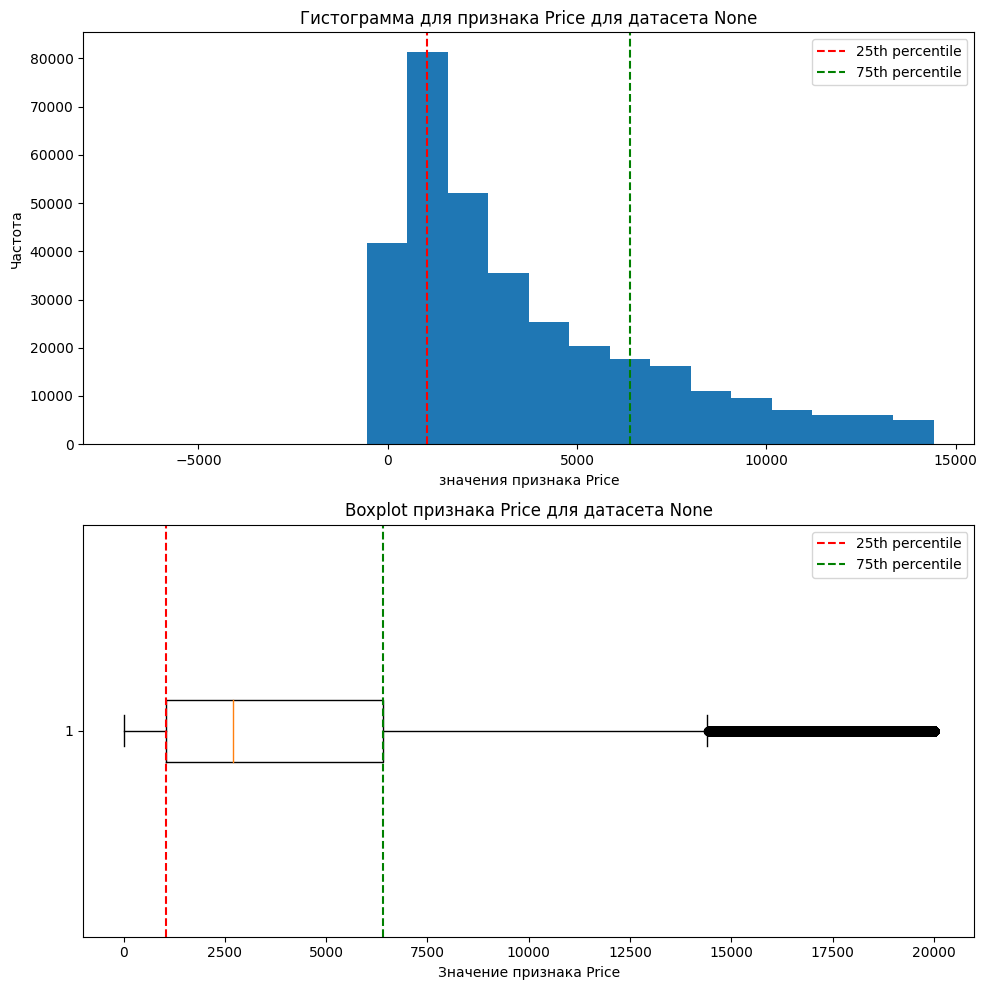

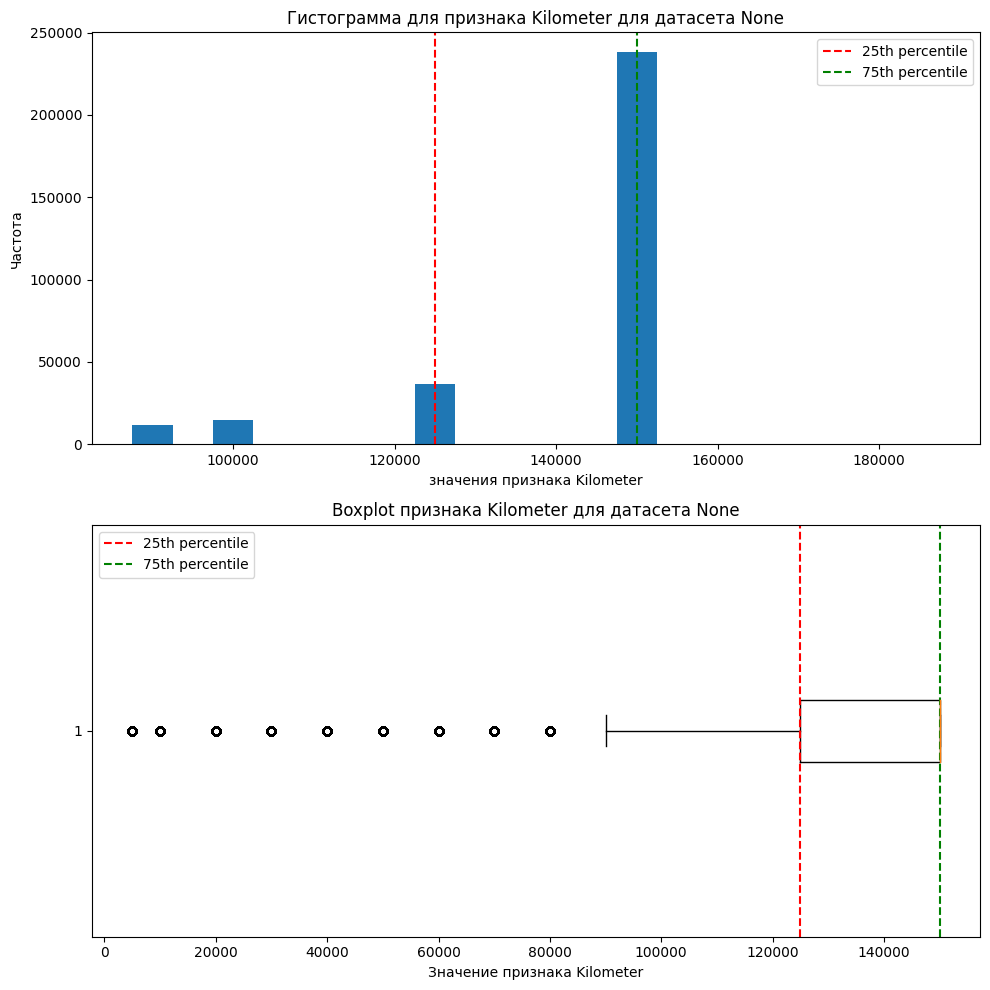

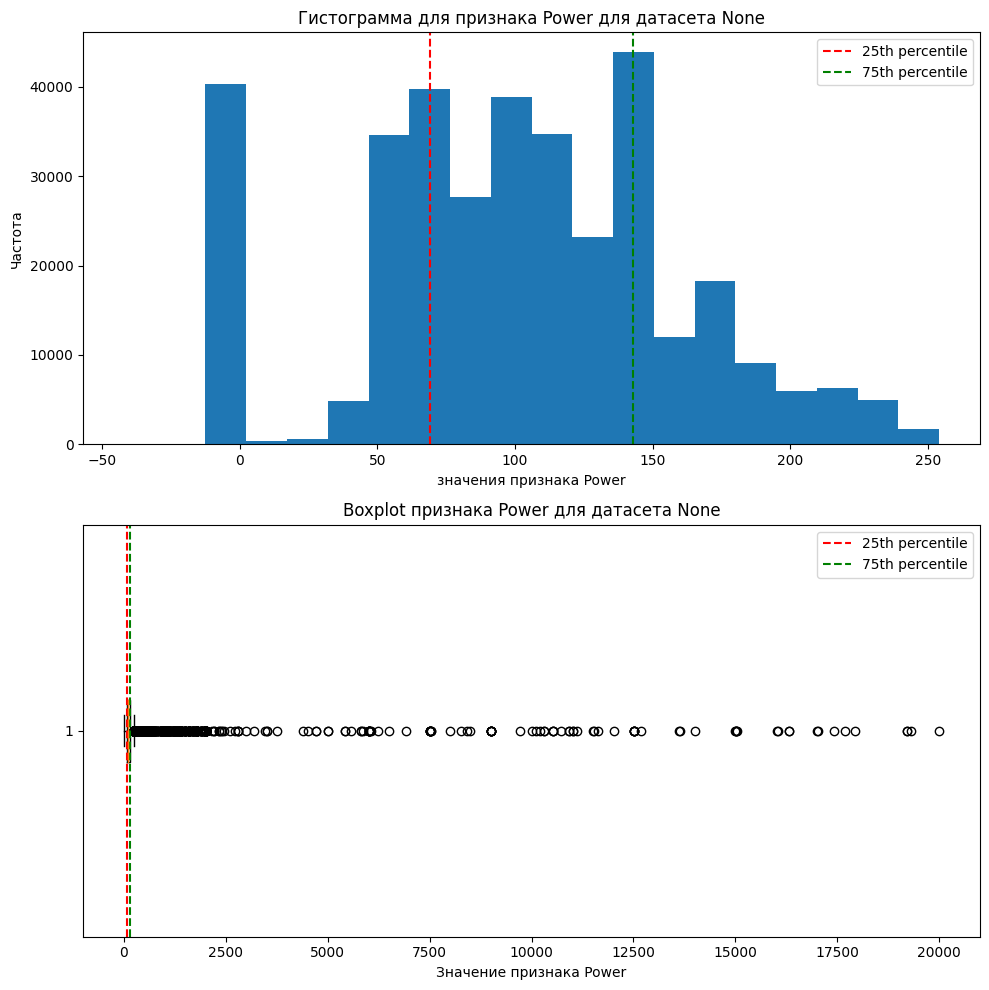

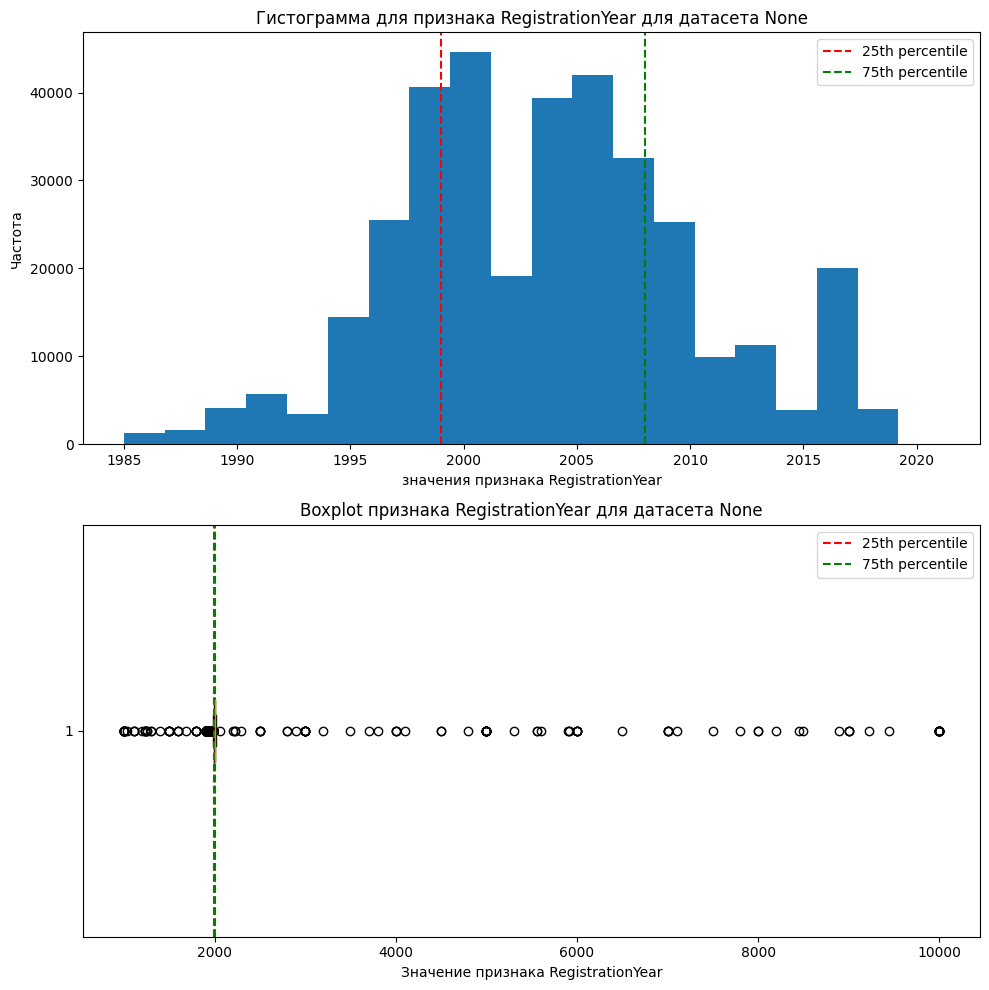

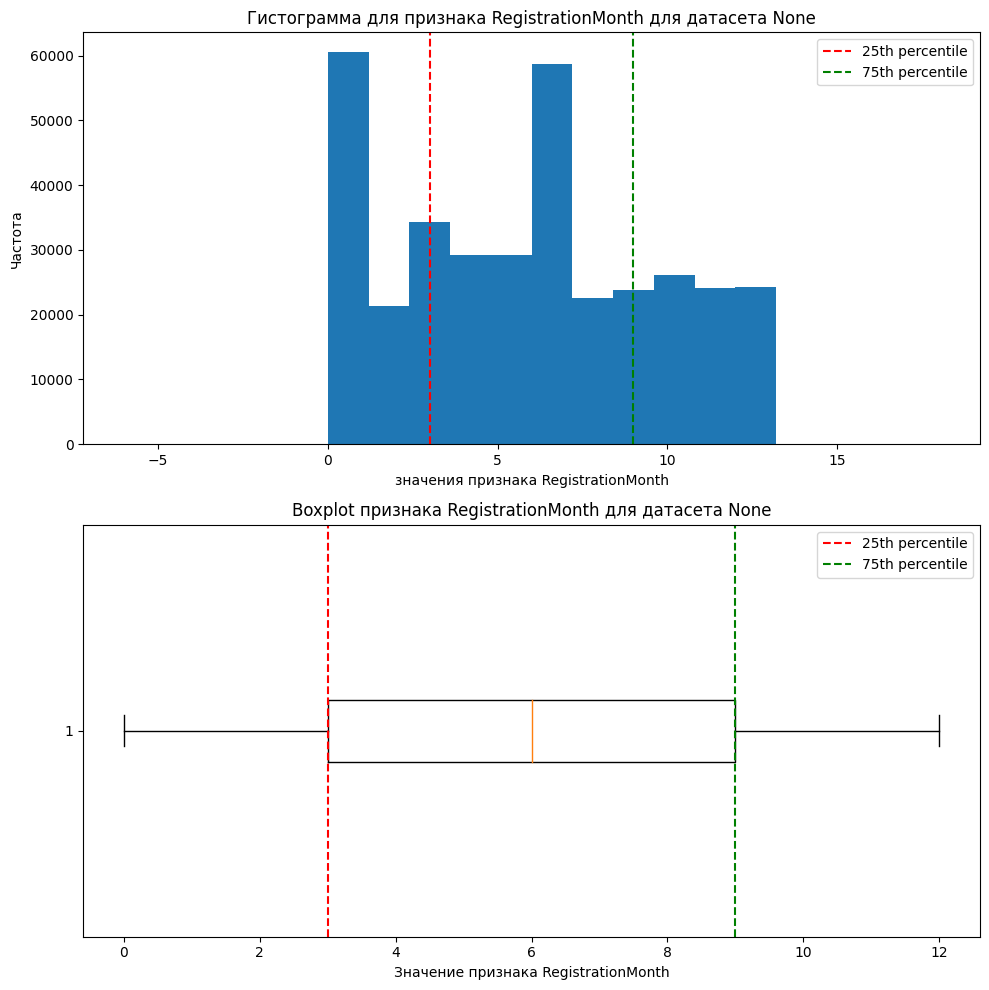

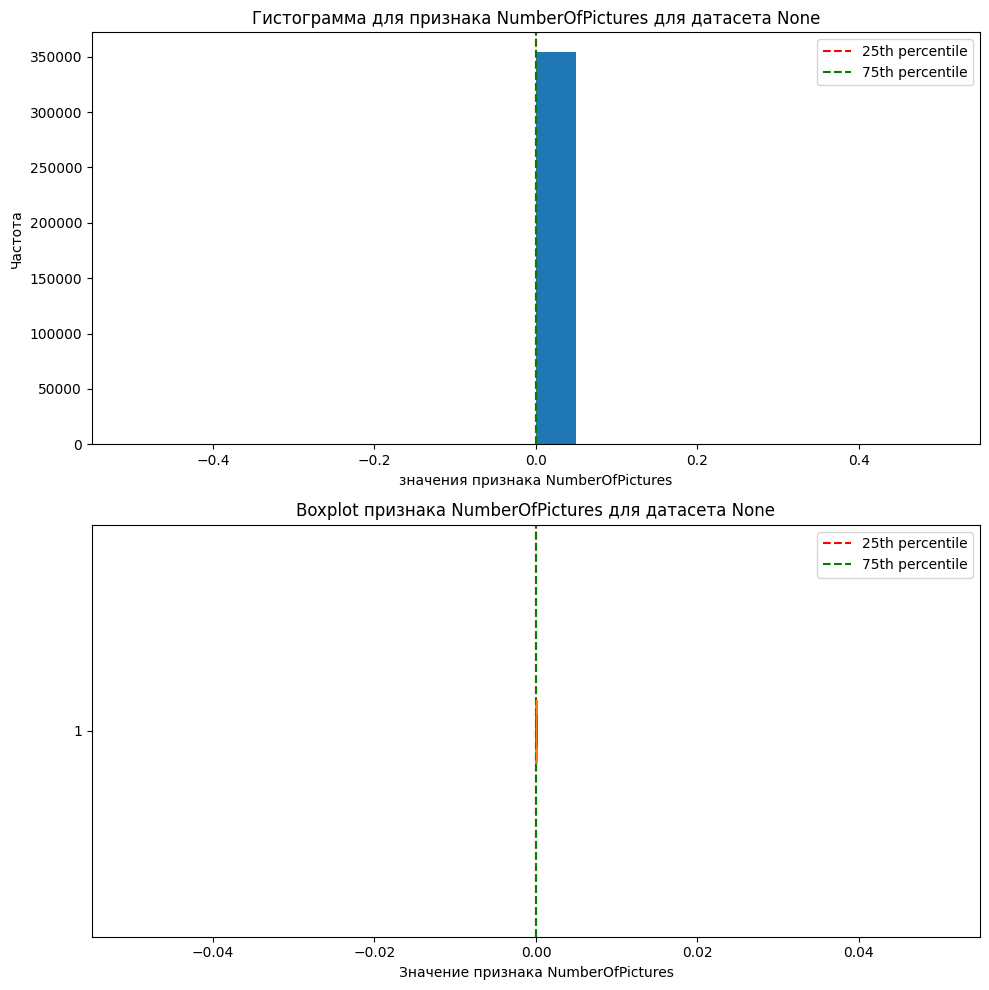

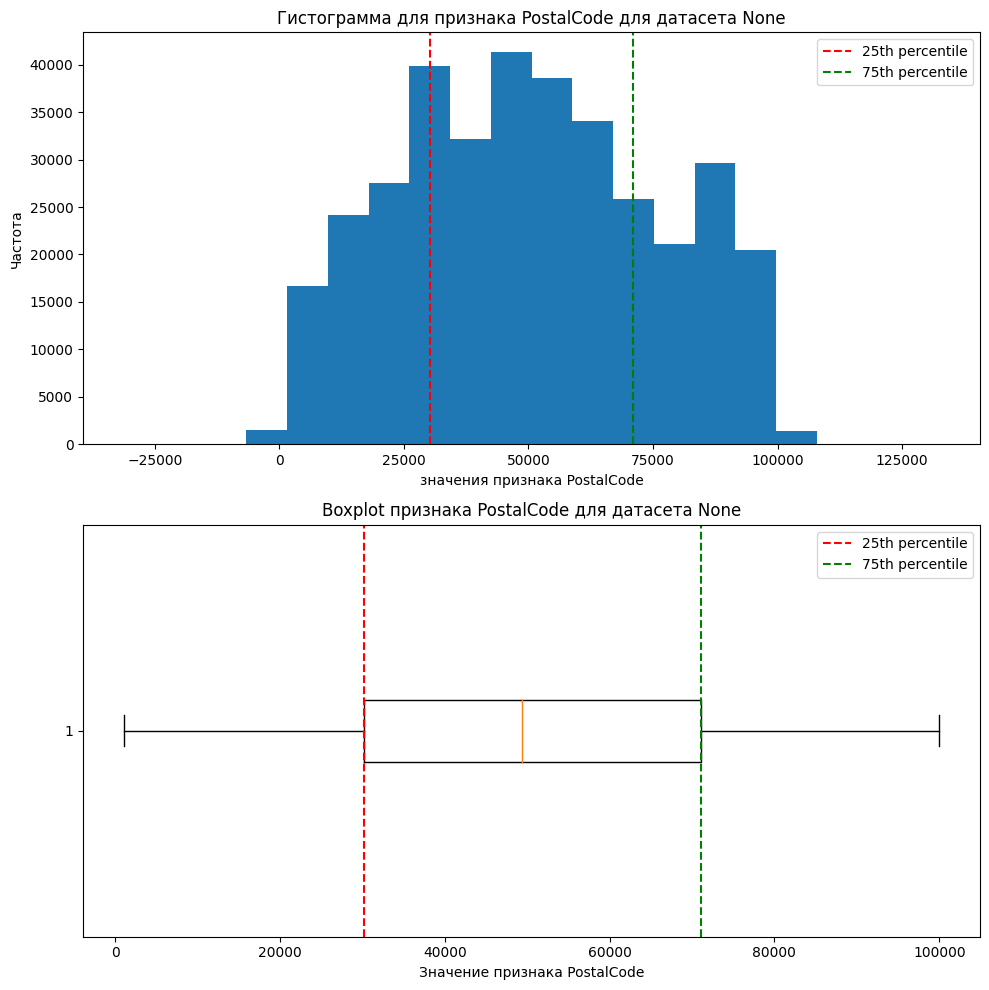

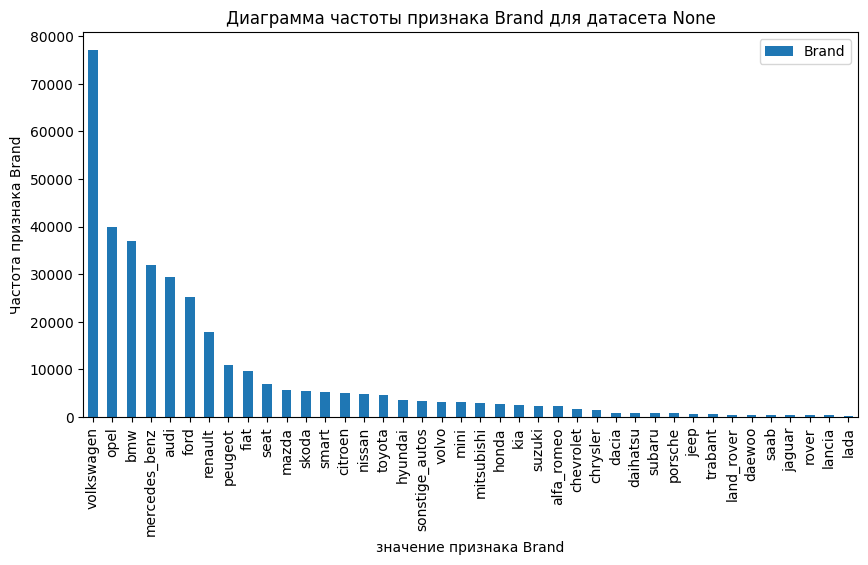

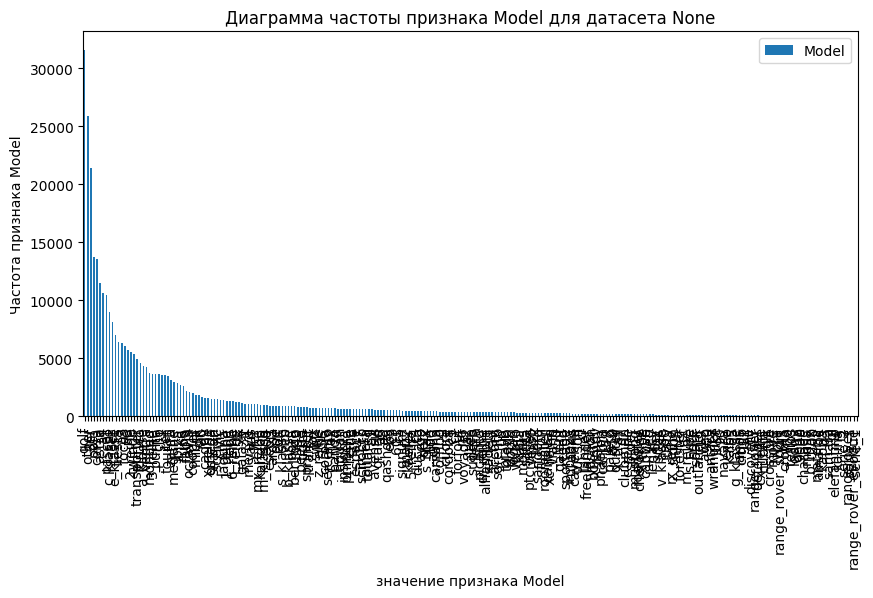

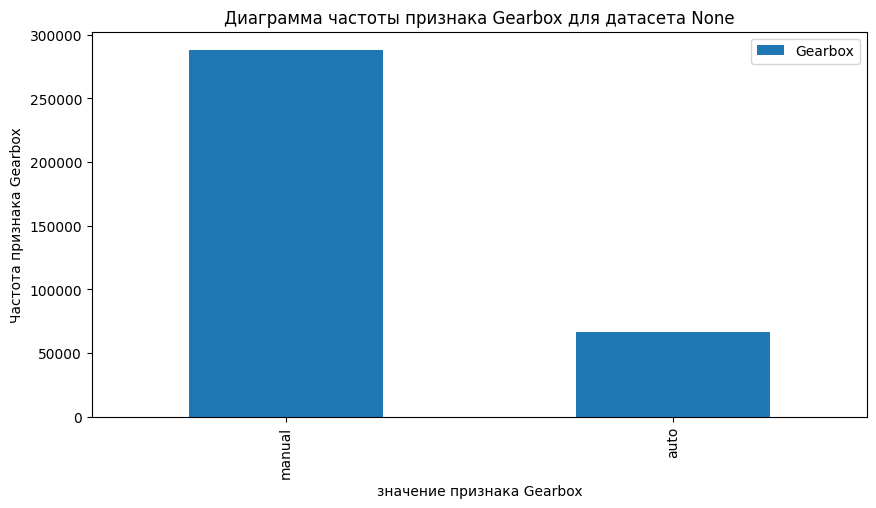

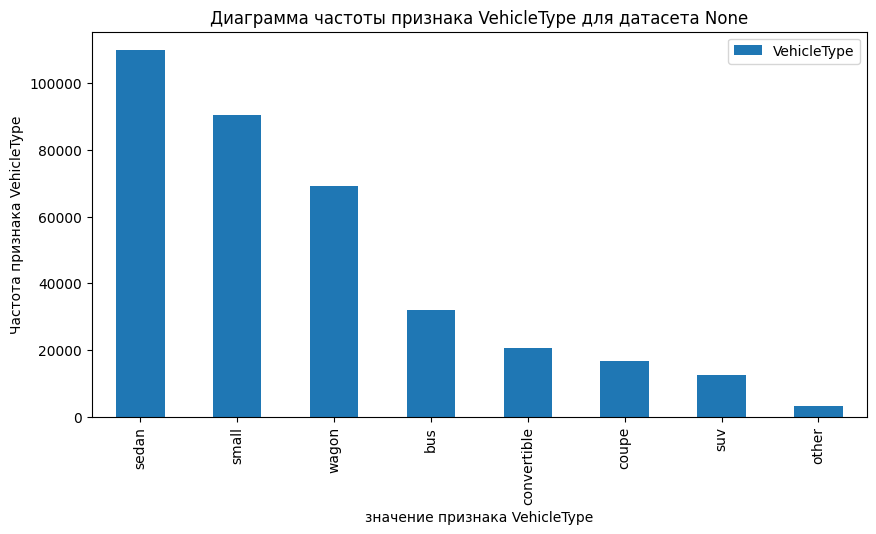

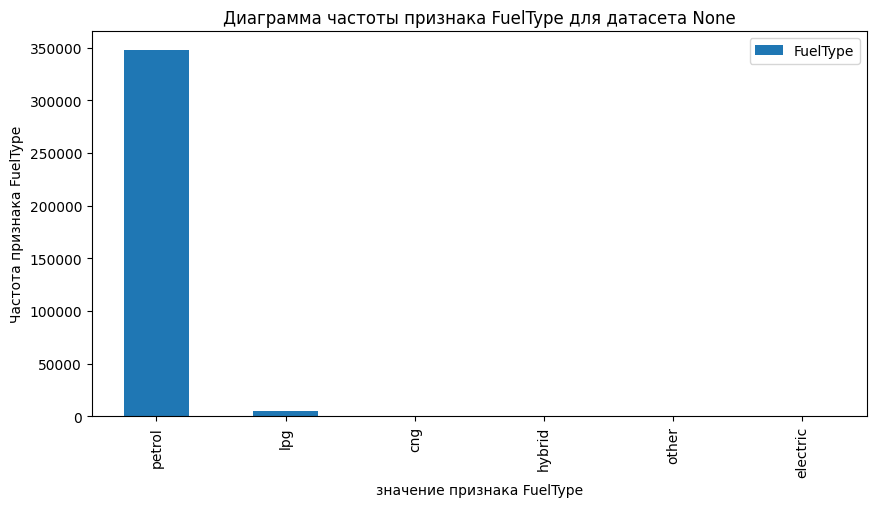

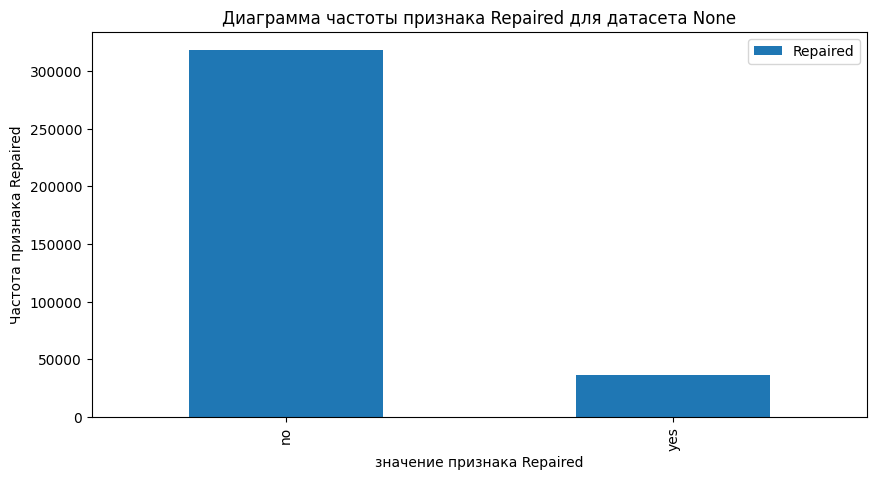

In [191]:
analysis_df(data.drop(['DateCrawled', 'DateCreated',
       'LastSeen'], axis=1), dropna=False)

Большая часть машин - это неремонтированные седаны марки VW с бензиновым двигателем , ручной коробкой передач.

Теперь пройдемся по остальным признакам

In [192]:
data.NumberOfPictures.unique()

array([0])

#### 1.3.1 Число фотографий - бесполезный. Удаляем

In [193]:
data.drop('NumberOfPictures', axis=1, inplace=True)

#### 1.3.2 Целевой признак - цена

In [194]:
#создадим функцию для концов усов боксплота
def print_bp(data, col_name):
    q25, q75 = data[col_name].quantile(0.25), data[col_name].quantile(0.75)
    min_val = int(q25- 1.5*(q75-q25))
    max_val= int(q75 +  1.5*(q75-q25))

    return f'Левый ус {min_val}, правый ус {max_val}'

In [195]:
print_bp(data, 'Price')

'Левый ус -6975, правый ус 14425'

Итак, у цены много выбросов - все, что дороже 14500 евро.

Но значение цены не выходит за границы 20_000 евро. Значит, ошибок нет - это небольшой сегмент дорогих машин. 

Пренебрегать этими данными нельзя.

А вот цены меньше 100 евро удалим, чтобы они не заставляли модель ошибаться

In [196]:
data= data.query('Price> 99')

#### 1.3.3 Пробег

вообще правильнее отразить в форме столбчатой диаграммы

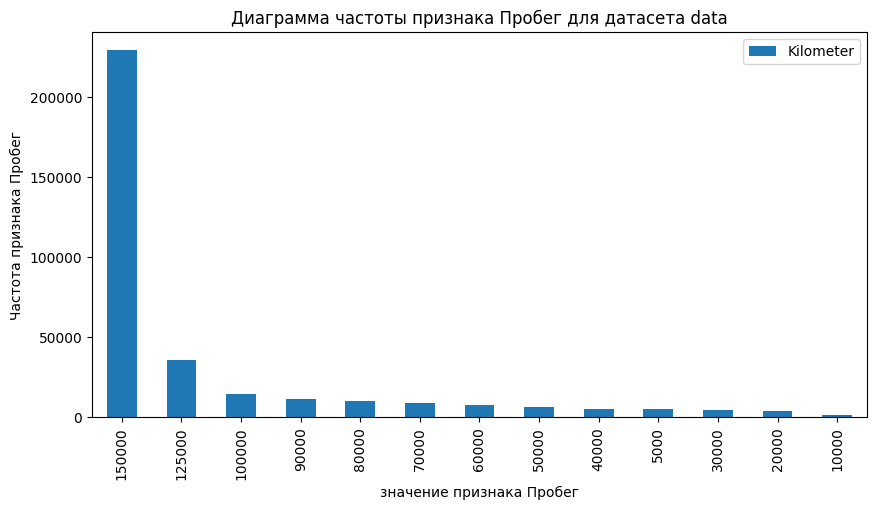

In [197]:
barplot_df(data, 'Kilometer', 'Пробег','data')

Большая часть машин продается с пробегом 150_000 км и более, далее до 125_000 км. Остальных примерно поровну

#### 1.3.4 Мощность

По мощности явно есть проблемы - основная масса лежит в диапазоне от 0 до 250 л.с

Но есть большое число выбросов - например, с мощностью, измеряемой в тысячах лс (явная опечатка):
- больше 1000 будем укорачивать на порядок
- больше 10_000 - на два порядка

In [198]:
print_bp(data, 'Power')

'Левый ус -39, правый ус 252'

In [199]:
def make_power_true(pow):
    if 400<pow<3_000: return int(pow/10)
    elif pow>=3_000: return int(pow/100)
    else: return pow

In [200]:
data.Power = data.Power.apply(make_power_true)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Статистический анализ таблицы None


,count,mean,std,min,25%,50%,75%,max
Power,341051.0,107.490633,61.659918,0.0,69.0,105.0,143.0,400.0


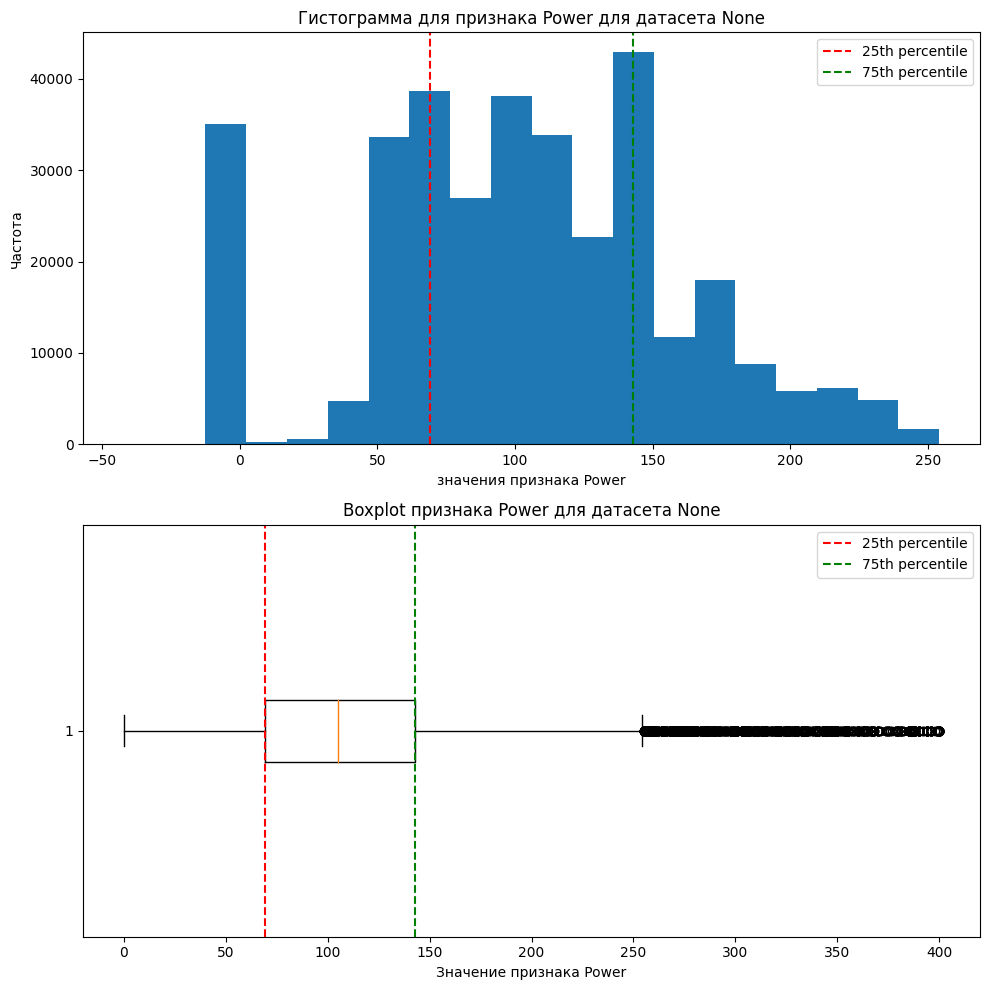

In [201]:
analysis_df(data[['Power']])

Остальные машины считаем мощными

#### 1.3.5 Год регистрации

есть явные проблемы с годом регистрации автомобиля дальше, чем дата создания анкеты - этого не может быть



In [202]:
data.DateCreated.dt.year.max()

2016

Нижнюю границу по году регистрации выберем из здравого смысла - оставим 1970 год.

Все остальное - отсечем

In [203]:
filtered_data = data.query('1970 < RegistrationYear < 2016')

In [204]:
filtered_data.shape

(317143, 15)

In [205]:
print(f'Отфильтровали {int((1- filtered_data.shape[0]/data.shape[0]) * 100)}% данных ')

Отфильтровали 7% данных 


#### 1.3.6. Еще раз взглянем на признаки в данных после работы с ними

Статистический анализ таблицы None


,count,mean,std,min,25%,50%,75%,max
Price,317143.0,4693.301823,4551.897539,100.0,1250.0,2999.0,6800.0,20000.0
Kilometer,317143.0,128409.613329,37056.881190,5000.0,125000.0,150000.0,150000.0,150000.0
Power,317143.0,109.802692,60.939644,0.0,75.0,105.0,143.0,400.0
RegistrationYear,317143.0,2002.421971,6.005611,1971.0,1999.0,2003.0,2007.0,2015.0
RegistrationMonth,317143.0,5.878891,3.655063,0.0,3.0,6.0,9.0,12.0
PostalCode,317143.0,50876.716633,25756.342930,1067.0,30539.0,49716.0,71522.0,99998.0


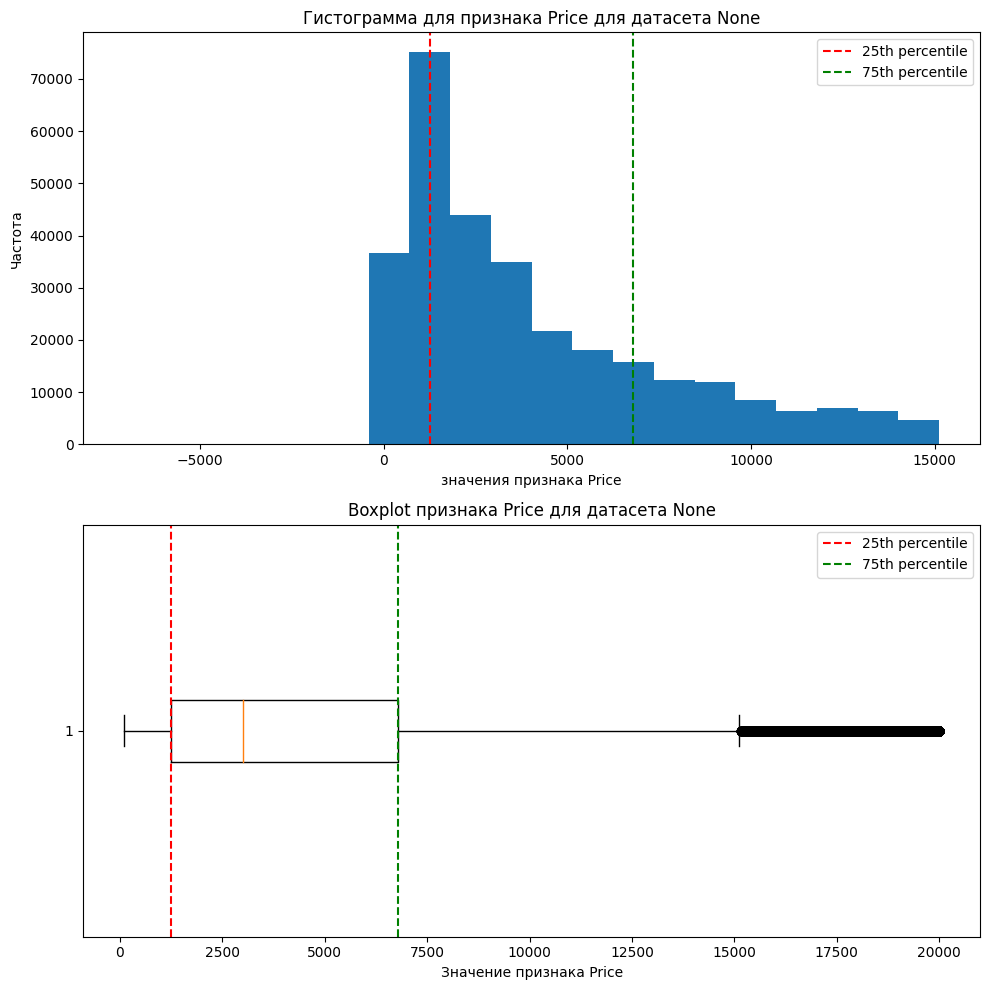

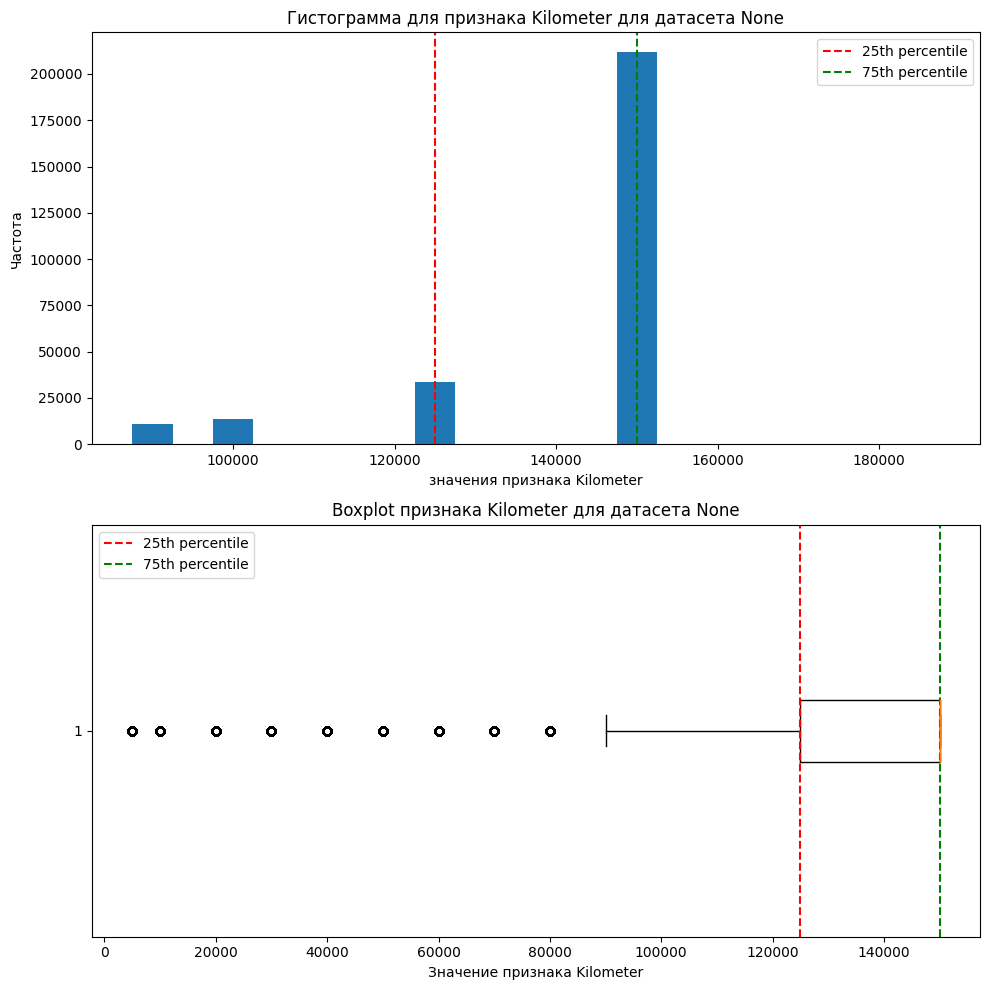

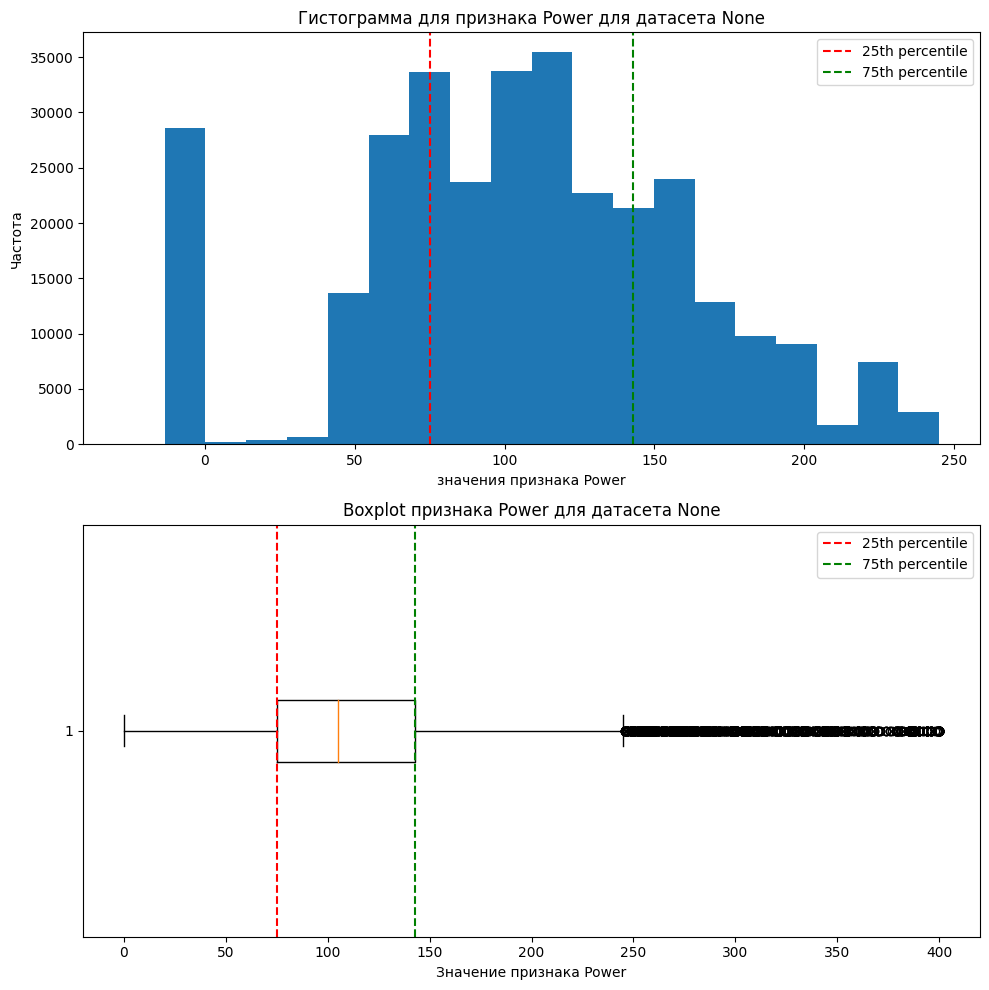

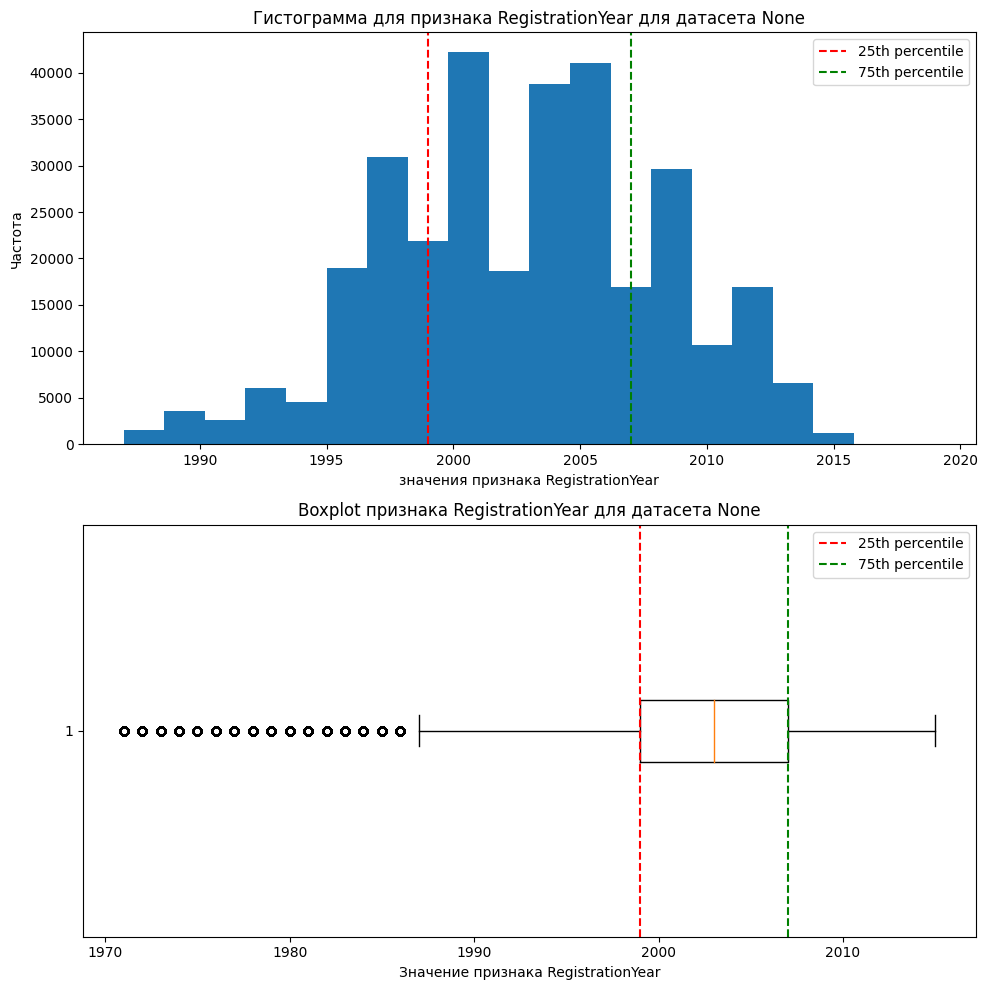

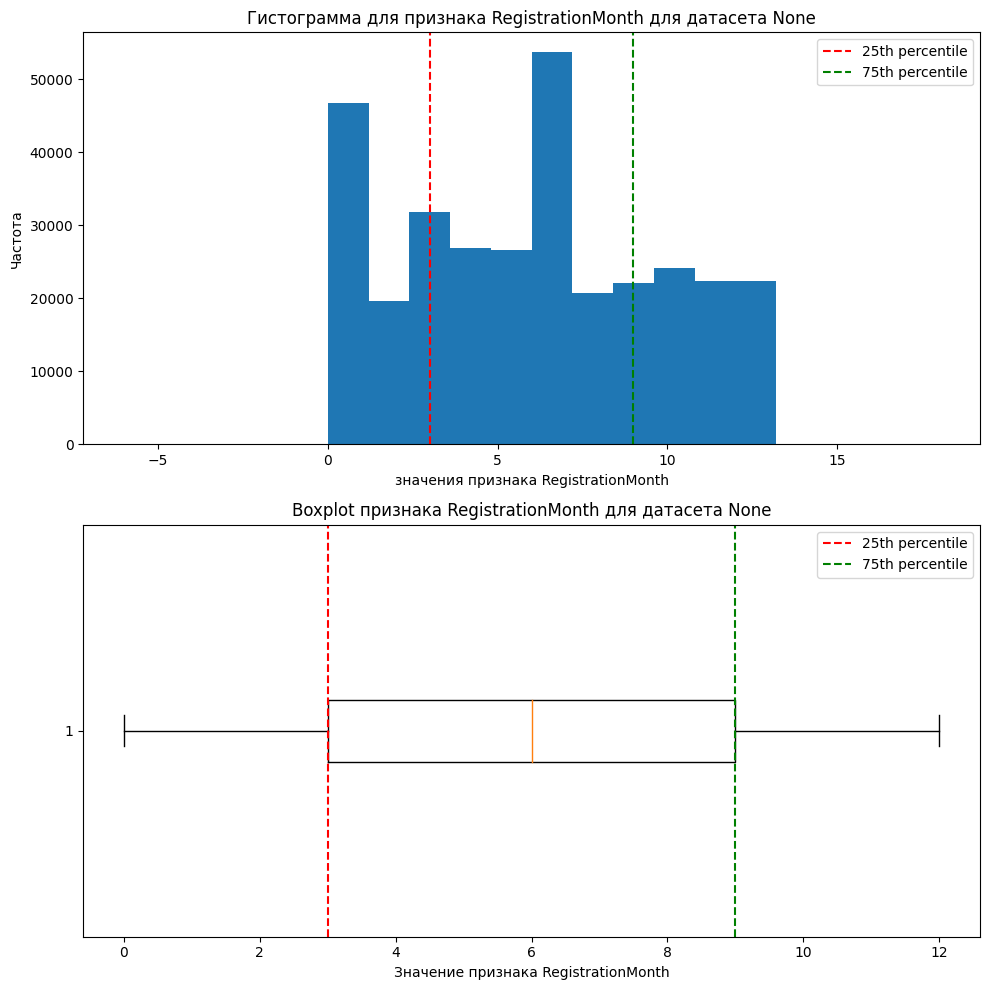

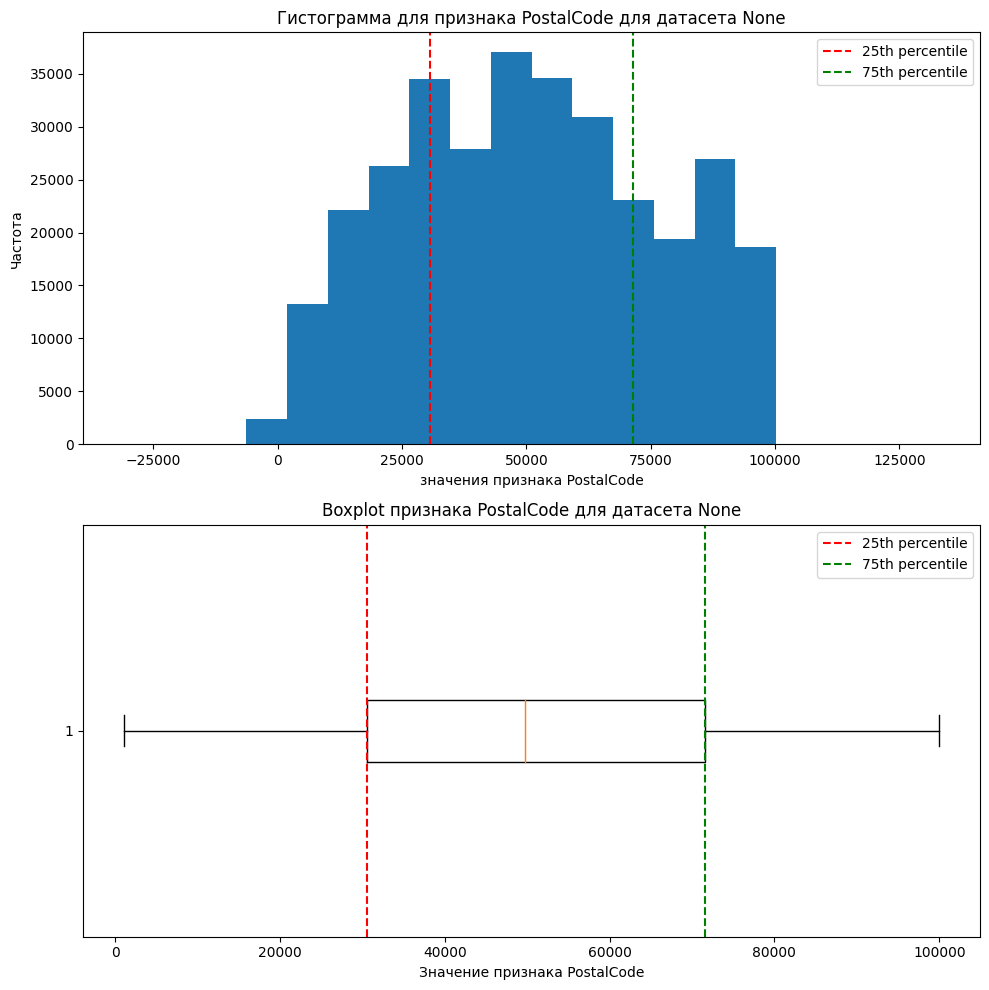

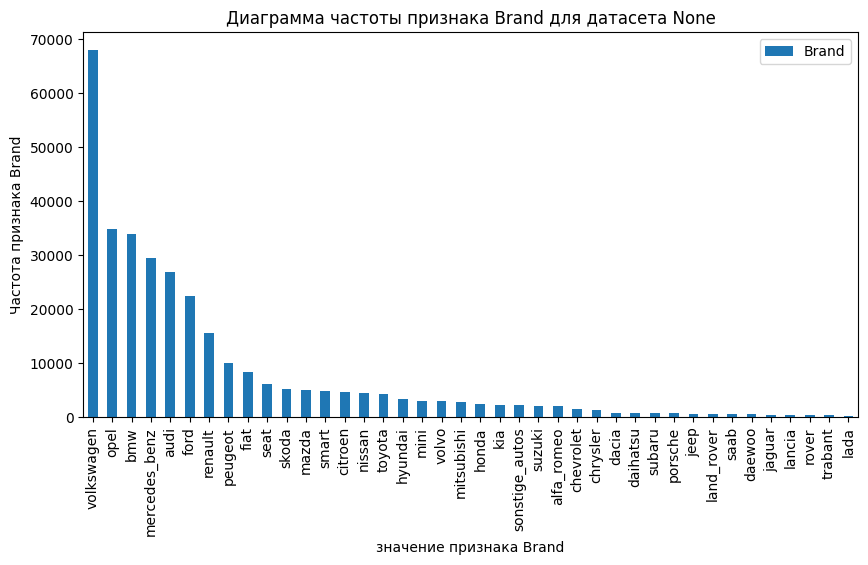

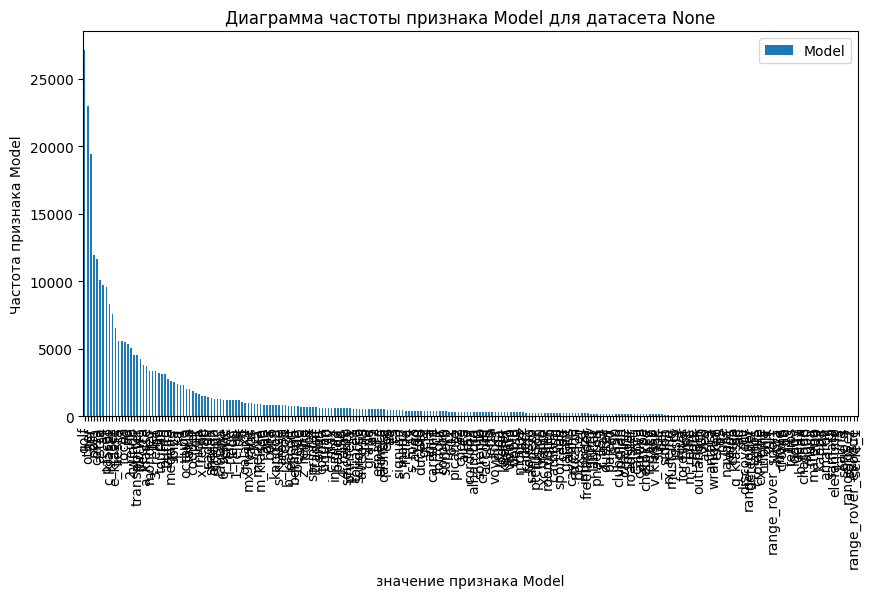

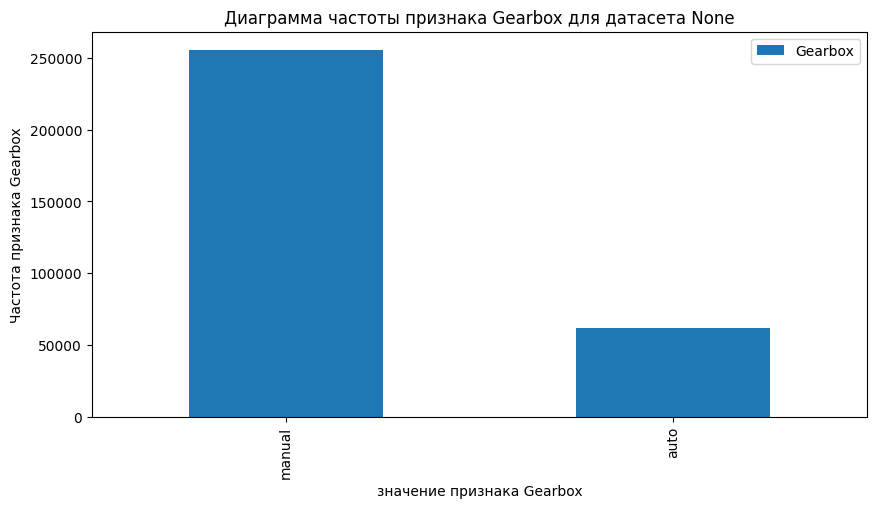

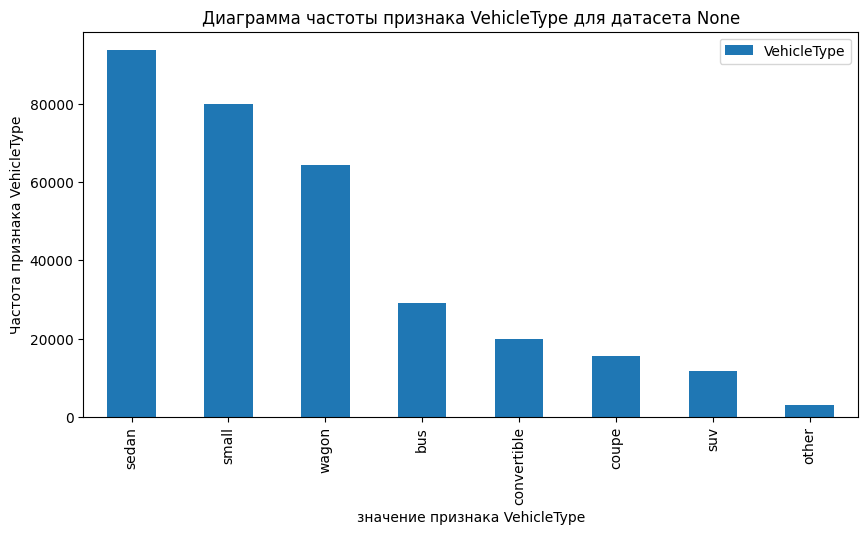

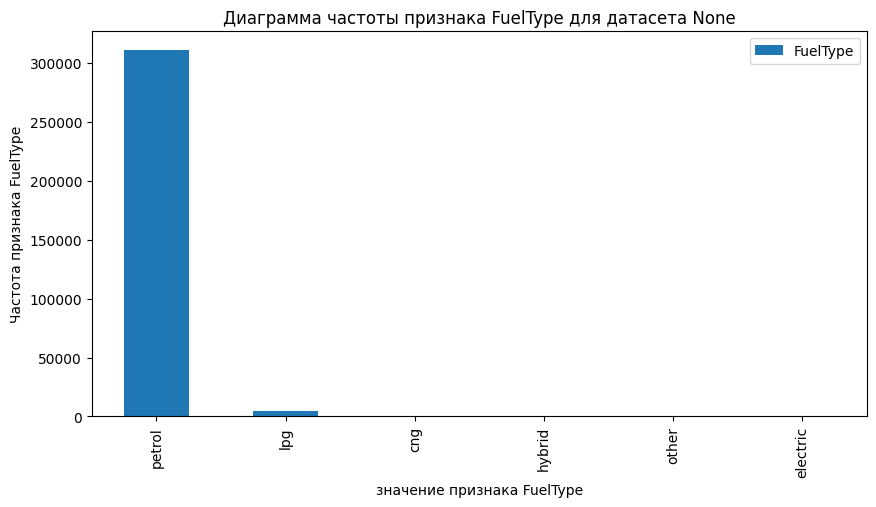

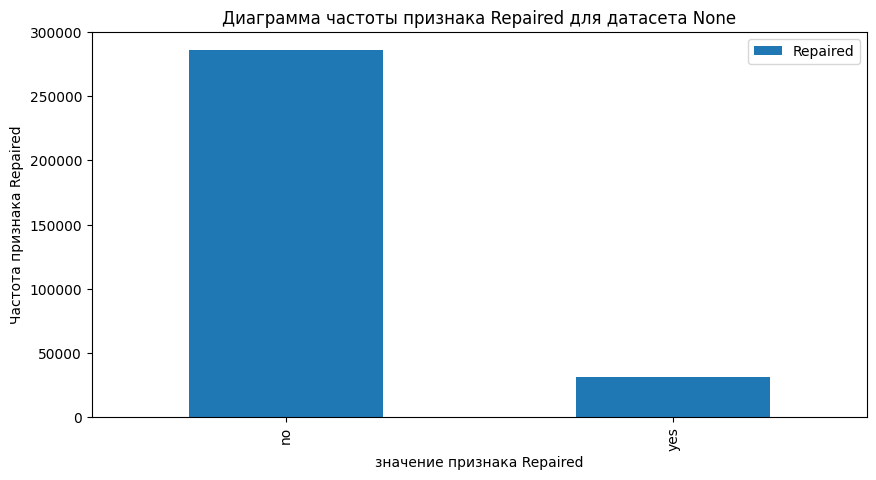

In [206]:
analysis_df(filtered_data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1))

### 1.4 Исключение ненужных столбцов

- мы уже убрали неинформативный столбец с фотографиями машины (признак был бы интересен, но в данных все заполнено нулями)

- теперь избавимся от столбцов с датами - никакой из этих признаков не принесет нам информации о стоимости машины (дата создания анкеты, дата выгрузки анкеты, дата последнего визита пользователя) 

In [207]:
filtered_data.columns

Index(['Price', 'Brand', 'Model', 'Kilometer', 'Power', 'RegistrationYear',
       'RegistrationMonth', 'Gearbox', 'VehicleType', 'FuelType', 'Repaired',
       'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen'],
      dtype='object')

In [208]:
df = filtered_data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1).copy()

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317143 entries, 0 to 354364
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              317143 non-null  int64 
 1   Brand              317143 non-null  object
 2   Model              317143 non-null  object
 3   Kilometer          317143 non-null  int64 
 4   Power              317143 non-null  int64 
 5   RegistrationYear   317143 non-null  int64 
 6   RegistrationMonth  317143 non-null  int64 
 7   Gearbox            317143 non-null  object
 8   VehicleType        317143 non-null  object
 9   FuelType           317143 non-null  object
 10  Repaired           317143 non-null  object
 11  PostalCode         317143 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 31.5+ MB


### 1.5 Корреляционный анализ данных

Выделим числовые и категориальные признаки в отдельные переменные

In [216]:
num_cols= ['Price', 'Power', 'PostalCode']

cat_cols = ['Brand',
 'Model',
 'Kilometer',        # это скорее категориальный ранговый показатель в наших данных
 'RegistrationYear', # дискретный
'RegistrationMonth', # дискретный
 'Gearbox',
 'VehicleType',
 'FuelType',
 'Repaired']

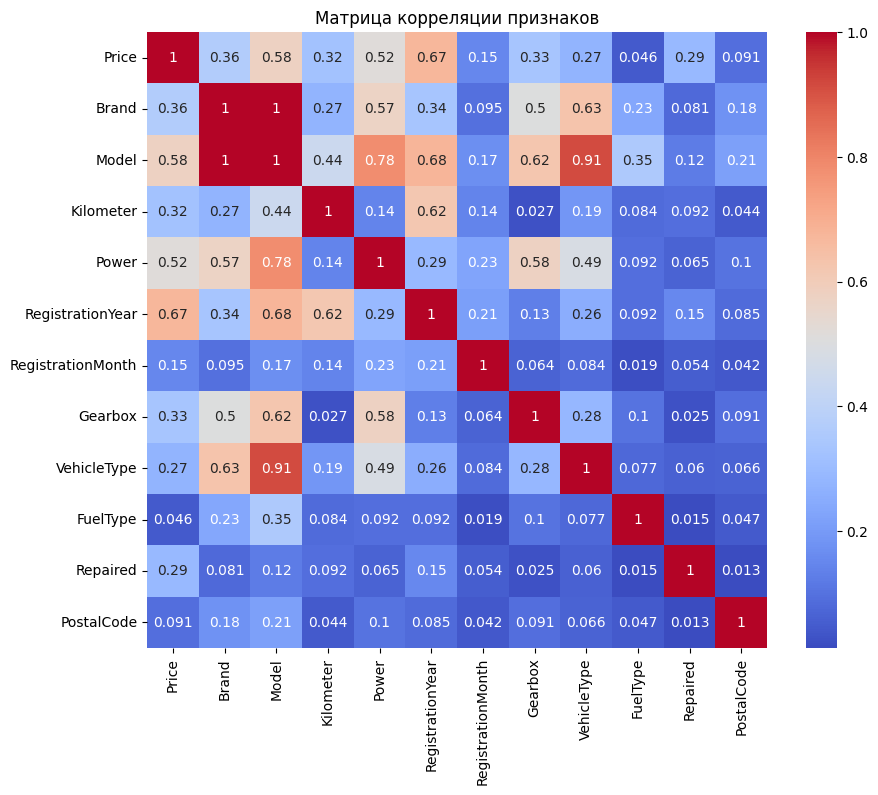

In [217]:
corr_matrix = phik_matrix(df, interval_cols=num_cols)
plt.figure(figsize=(10,8))
plt.title('Матрица корреляции признаков')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

В общем, никаких сюрпризов:
- цена хорошо коррелирует с годом регистрации, мощностью моделью. Хуже с типом кузова, фактом ремонта, коробкой передач, брендом и пробегом. И практически никак с пмж продавца и типом топлива
- бренд хорошо коррелирует с маркой (очевидно, учитывая что мы заполняли пустые значения исходя из бренда)
- модель и тип кузова - высокая корреляция (тоже все очевидно)
- неплохая корреляция коробки передач с моделью (чаще всего модель выпускают с конкретной коробкой)

В целом, признаки устраивают, но нужно избавляться либо от модели, либо от бренда - у них стопроцентная корреляция

Объединим их в один параметр brand_model

In [218]:
df.head()

,Price,Brand,Model,Kilometer,Power,RegistrationYear,RegistrationMonth,Gearbox,VehicleType,FuelType,Repaired,PostalCode
0,480,volkswagen,golf,150000,0,1993,0,manual,sedan,petrol,no,70435
1,18300,audi,a4,125000,190,2011,5,manual,coupe,petrol,yes,66954
2,9800,jeep,grand,125000,163,2004,8,auto,suv,petrol,no,90480
3,1500,volkswagen,golf,150000,75,2001,6,manual,small,petrol,no,91074
4,3600,skoda,fabia,90000,69,2008,7,manual,small,petrol,no,60437


In [221]:
df['brand_model'] = df.Brand.astype(str) + '_' + df.Model.astype(str)

In [222]:
df.head()

,Price,Brand,Model,Kilometer,Power,RegistrationYear,RegistrationMonth,Gearbox,VehicleType,FuelType,Repaired,PostalCode,brand_model
0,480,volkswagen,golf,150000,0,1993,0,manual,sedan,petrol,no,70435,volkswagen_golf
1,18300,audi,a4,125000,190,2011,5,manual,coupe,petrol,yes,66954,audi_a4
2,9800,jeep,grand,125000,163,2004,8,auto,suv,petrol,no,90480,jeep_grand
3,1500,volkswagen,golf,150000,75,2001,6,manual,small,petrol,no,91074,volkswagen_golf
4,3600,skoda,fabia,90000,69,2008,7,manual,small,petrol,no,60437,skoda_fabia


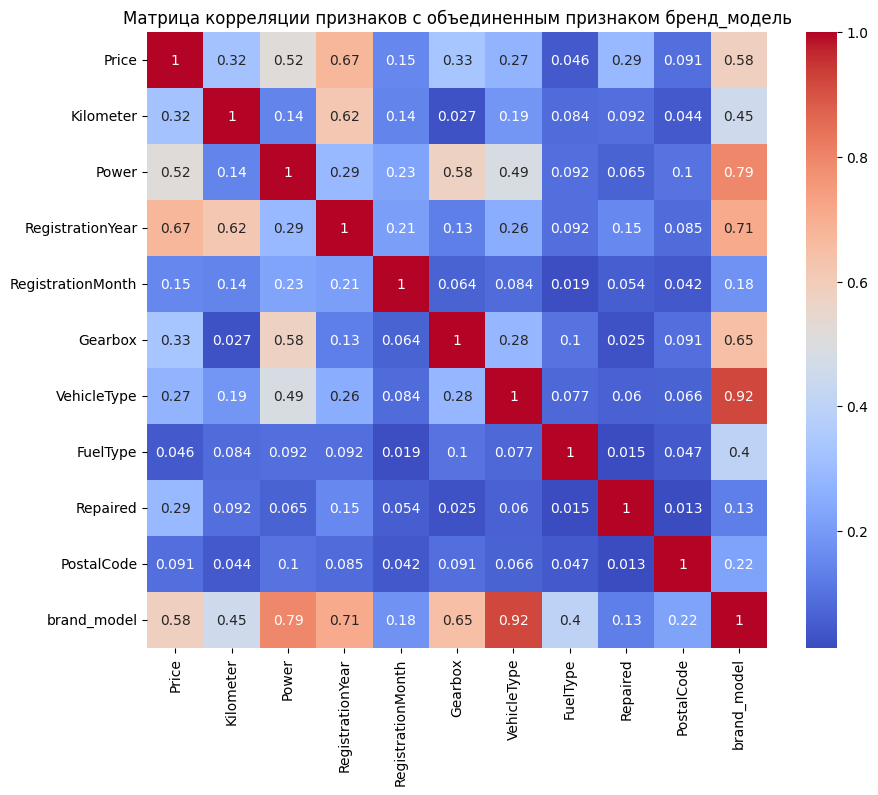

In [223]:
corr_matrix = phik_matrix(df.drop(['Brand', 'Model'], axis=1), interval_cols=num_cols)
plt.figure(figsize=(10,8))
plt.title('Матрица корреляции признаков с объединенным признаком бренд_модель')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [225]:
# хоршее решение, перезапишем датафрейм

df.drop(['Brand', 'Model'], axis=1, inplace=True)

In [226]:
df.head()

,Price,Kilometer,Power,RegistrationYear,RegistrationMonth,Gearbox,VehicleType,FuelType,Repaired,PostalCode,brand_model
0,480,150000,0,1993,0,manual,sedan,petrol,no,70435,volkswagen_golf
1,18300,125000,190,2011,5,manual,coupe,petrol,yes,66954,audi_a4
2,9800,125000,163,2004,8,auto,suv,petrol,no,90480,jeep_grand
3,1500,150000,75,2001,6,manual,small,petrol,no,91074,volkswagen_golf
4,3600,90000,69,2008,7,manual,small,petrol,no,60437,skoda_fabia


#### 1.6 Финальные причесывания - имена колонок приведем в удобную форму

In [229]:
df.columns = df.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower()
df.columns

Index(['price', 'kilometer', 'power', 'registration_year',
       'registration_month', 'gearbox', 'vehicle_type', 'fuel_type',
       'repaired', 'postal_code', 'brand_model'],
      dtype='object')

​
## 2.  Обучение моделей


### 2.1 Разделим признаки

In [230]:
ohe_cols = ['repaired', 'gearbox', 'fuel_type']
ord_cols = [ 'kilometer', 'registration_year','registration_month', 'vehicle_type', 'brand_model']
num_cols = ['power', 'postal_code']

### 2.2 Создадим пайплайны

In [231]:
ohe_pl = Pipeline(
    [
        ('ohe_imp', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

ord_pl = Pipeline( 
    [
        ('ord_imp', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('ord_imp_post', SimpleImputer(strategy='most_frequent', missing_values=np.nan))
    ]
)

col_transformer = ColumnTransformer(
    [
        ('ohe', ohe_pl, ohe_cols),
        ('ord', ord_pl, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

In [232]:
final_pl = Pipeline(
    [
        ('prep', col_transformer),
        ('models', LinearRegression())
    ]
)

### 2.3 Разобьем данные на тренировочную и тестовую выборки

In [233]:
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 2.4 Подбор параметров и обучение моделей

Обучать будем:
- линейную регрессию
- CatBoostRegressor
- LGBMRegressor

- XGBRegressor
- DecisionTreeRegressor

In [ ]:
params = [
    {
        'models': [CatBoostRegressor(random_state=42, verbose=10)],
        'models__learning_rate':  [0.1, 0.25], 
        'models__max_depth': [10, 12],
        'models__n_estimators': [200], 
        'prep__num': ['passthrough']
    },
    {
        'models': [XGBRegressor(random_state=42)],
        'models__learning_rate':  [0.1, 0.12],
        'models__max_depth': [10, 12],
        'models__n_estimators': [200],
        'prep__num': ['passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(3, 5),
        'models__min_samples_split': range(3, 5),
        'models__min_samples_leaf': range(3, 5),
        'prep__num': ['passthrough']
    }
]

​
## 3.  Анализ моделей
